In [1]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

### Turning the Given Dataset to a List

In [9]:
with open("adverts_dataset.txt", "r") as text_file:
    data = [(line.split()[2]) for line in text_file]
    
#print(data)

In [27]:
NUM_TRIALS = 10000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.6, 0.75, 0.8]
EPS = 0.2

### Thompson Sampling

In [23]:
class TS_Bandit:
  def __init__(self, p):
    self.p = p
    self.a = 1
    self.b = 1
    self.N = 0 # for information only

  def pull(self):
    return np.random.random() < self.p

  def sample(self):
    return np.random.beta(self.a, self.b)

  def update(self, x):
    self.a += x
    self.b += 1 - x
    self.N += 1

In [24]:
def plot(bandits, trial):
  x = np.linspace(0, 1, 200)
  for b in bandits:
    y = beta.pdf(x, b.a, b.b)
    plt.plot(x, y, label=f"real p: {b.p:.4f}, win rate = {b.a - 1}/{b.N}")
  plt.title(f"Bandit distributions after {trial} trials")
  plt.legend()
  plt.show()

In [28]:
def ts_experiment(dataset):
  bandits = [TS_Bandit(p) for p in BANDIT_PROBABILITIES]

  sample_points = dataset
  rewards = np.zeros(NUM_TRIALS)
  for i in range(NUM_TRIALS):
    # Thompson sampling
    j = np.argmax([b.sample() for b in bandits])

    # plot the posteriors
    if i in sample_points:
      plot(bandits, i)

    # pull the arm for the bandit with the largest sample
    x = bandits[j].pull()

    # update rewards
    rewards[i] = x

    # update the distribution for the bandit whose arm we just pulled
    bandits[j].update(x)

  # print total reward
  print("total reward earned:", rewards.sum())
  print("overall win rate:", rewards.sum() / NUM_TRIALS)
  print("num times selected each bandit:", [b.N for b in bandits])

In [29]:
ts_experiment(data)

total reward earned: 7918.0
overall win rate: 0.7918
num times selected each bandit: [5, 41, 34, 627, 9293]


### Epsilon Greedy

In [41]:
class EG_Bandit:
  def __init__(self, p):
    # p: the win rate
    self.p = p
    self.p_estimate = 0.
    self.N = 0. # num samples collected so far

  def pull(self):
    # draw a 1 with probability p
    return int(np.random.random() < self.p)

  def update(self, x):
    self.N += 1.
    self.p_estimate = ((self.N - 1)*self.p_estimate + x) / self.N

In [44]:
def eg_experiment(adaptiveEpsilon  = False):
    bandits = [EG_Bandit(p) for p in BANDIT_PROBABILITIES]

    rewards = np.zeros(NUM_TRIALS)
    num_times_explored = 0
    num_times_exploited = 0
    num_optimal = 0
    optimal_j = np.argmax([b.p for b in bandits])
    print("optimal bandit:", optimal_j + 1) # +1 since index starts at 0

    for i in range(NUM_TRIALS):
        if adaptiveEpsilon:
            e = 1 / (i+.0001)
        else:
            e = EPS
            
        # use epsilon-greedy to select the next bandit
        if np.random.random() < e:
            num_times_explored += 1
            j = np.random.randint(len(bandits))
        else:
            num_times_exploited += 1
            j = np.argmax([b.p_estimate for b in bandits])

        if j == optimal_j:
            num_optimal += 1

        # pull the arm for the bandit with the largest sample
        x = bandits[j].pull()

        # update rewards log
        rewards[i] = x

        # update the distribution for the bandit whose arm we just pulled
        bandits[j].update(x)

    
    # print mean estimates for each bandit
    c = 0
    for b in bandits:
        c += 1
        print(f"mean estimate for bandit {c}:", b.p_estimate)

    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / NUM_TRIALS)
    print("num_times_explored:", num_times_explored)
    print("num_times_exploited:", num_times_exploited)
    print("num times selected optimal bandit:", num_optimal) # +1 since index starts from zero

    # plot the results
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(NUM_TRIALS) + 1)
    plt.plot(win_rates)
    plt.plot(np.ones(NUM_TRIALS)*np.max(BANDIT_PROBABILITIES))
    plt.show()

optimal bandit: 5
mean estimate for bandit 1: 0.18932038834951456
mean estimate for bandit 2: 0.47607655502392343
mean estimate for bandit 3: 0.561521252796421
mean estimate for bandit 4: 0.7487179487179487
mean estimate for bandit 5: 0.8029521180847236
total reward earned: 7511.0
overall win rate: 0.7511
num_times_explored: 1986
num_times_exploited: 8014
num times selected optimal bandit: 8333


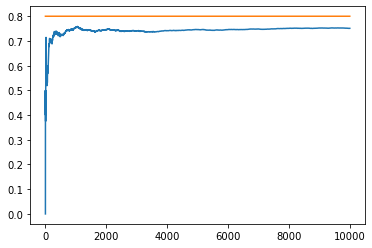

In [45]:
eg_experiment(adaptiveEpsilon = False)